In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import zipfile
zip_path = "/content/drive/MyDrive/celeba/celeba.zip"
extract_to = "/content/celeba_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extracted to:", extract_to)


Extracted to: /content/celeba_data


In [6]:
import os

img_dir = "/content/celeba_data/img_align_celeba/img_align_celeba"
print("Number of images:", len(os.listdir(img_dir)))
print("Sample file:", os.listdir(img_dir)[:5])


Number of images: 202599
Sample file: ['034084.jpg', '015986.jpg', '052725.jpg', '063340.jpg', '102062.jpg']


In [10]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms


In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def apply_random_mask(img_tensor):
    masked = img_tensor.clone()
    mask = torch.ones_like(masked)

    h, w = masked.shape[1], masked.shape[2]
    rect_h, rect_w = np.random.randint(60, 120, size=2)
    top = np.random.randint(0, h - rect_h)
    left = np.random.randint(0, w - rect_w)

    masked[:, top:top+rect_h, left:left+rect_w] = 1.0
    mask[:, top:top+rect_h, left:left+rect_w] = 0.0

    return masked, mask


In [11]:
img = Image.open(os.path.join(img_dir, "000001.jpg")).convert("RGB")
img_tensor = transform(img)

masked_img, binary_mask = apply_random_mask(img_tensor)


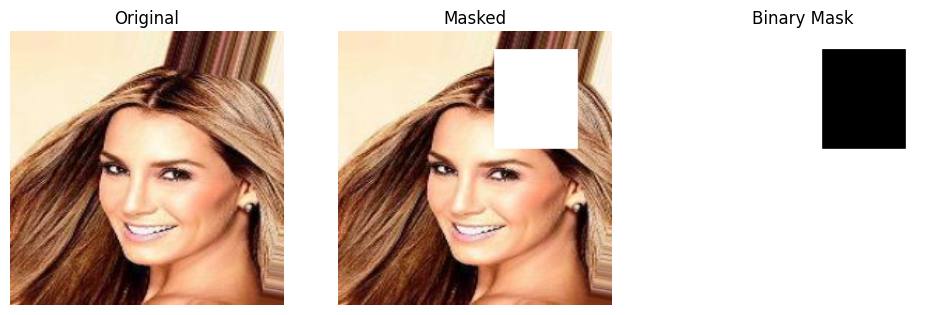

In [13]:
import matplotlib.pyplot as plt
def show_tensor(t, title):
    plt.imshow(t.permute(1, 2, 0).cpu())
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
show_tensor(img_tensor, "Original")

plt.subplot(1, 3, 2)
show_tensor(masked_img, "Masked")

plt.subplot(1, 3, 3)
show_tensor(binary_mask, "Binary Mask")
plt.show()


In [21]:
from torch.utils.data import Dataset
import os
from PIL import Image

class CelebADataset(Dataset):
    def __init__(self, img_dir, transform, max_images=50000):  # limit to 50k
        self.img_dir = img_dir
        self.transform = transform
        self.files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])[:max_images]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(img)

        masked_img, mask = apply_random_mask(img_tensor)
        return masked_img, mask, img_tensor


In [22]:
from torch.utils.data import DataLoader

dataset = CelebADataset(img_dir, transform, max_images=50000)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


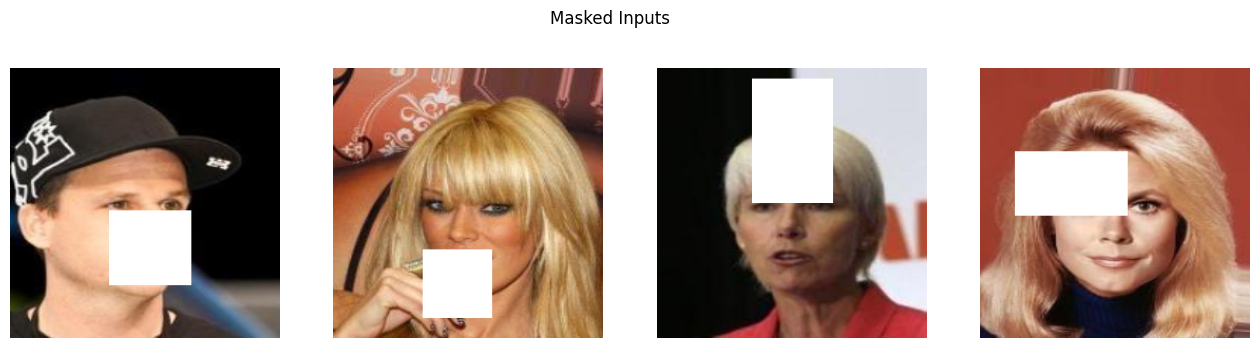

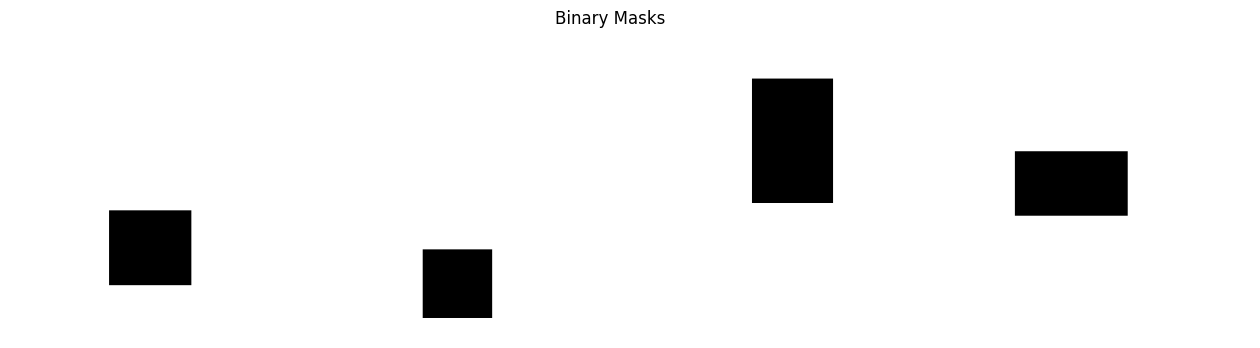

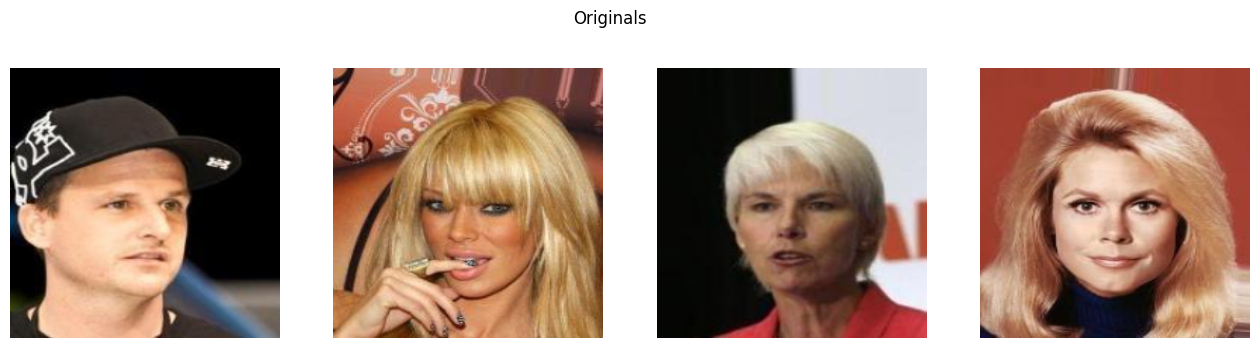

In [16]:
batch = next(iter(dataloader))
masked_imgs, masks, originals = batch

def show_batch(img_batch, title):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(4):
        axs[i].imshow(img_batch[i].permute(1, 2, 0))
        axs[i].axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(masked_imgs, "Masked Inputs")
show_batch(masks, "Binary Masks")
show_batch(originals, "Originals")


In [17]:
import torch.nn as nn

class InpaintingUNet(nn.Module):
    def __init__(self):
        super(InpaintingUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),  # 3 channels + 1 mask
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=5, padding=2),
            nn.Sigmoid()  # pixel values in [0,1]
        )

    def forward(self, x, mask):
        x = torch.cat([x, mask], dim=1)
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = InpaintingUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
scaler = torch.cuda.amp.GradScaler()


<ipython-input-23-ceeb931e9980>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [25]:
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

num_epochs = 5
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for masked_imgs, masks, originals in progress_bar:
        masked_imgs = masked_imgs.to(device)
        masks = masks[:, :1, :, :].to(device)
        originals = originals.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(masked_imgs, masks)
            loss = criterion(outputs * (1 - masks), originals * (1 - masks))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"✅ Epoch [{epoch+1}/{num_epochs}] Avg Loss: {running_loss / len(dataloader):.4f}")



<ipython-input-25-7c6b116081d3>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/5:   0%|          | 0/3125 [00:00<?, ?it/s]<ipython-input-25-7c6b116081d3>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5: 100%|██████████| 3125/3125 [19:24<00:00,  2.68it/s, loss=0.0176]


✅ Epoch [1/5] Avg Loss: 0.0209


Epoch 2/5: 100%|██████████| 3125/3125 [18:35<00:00,  2.80it/s, loss=0.0193]


✅ Epoch [2/5] Avg Loss: 0.0199


Epoch 3/5: 100%|██████████| 3125/3125 [18:25<00:00,  2.83it/s, loss=0.0192]


✅ Epoch [3/5] Avg Loss: 0.0197


Epoch 4/5: 100%|██████████| 3125/3125 [18:29<00:00,  2.82it/s, loss=0.0197]


✅ Epoch [4/5] Avg Loss: 0.0196


Epoch 5/5: 100%|██████████| 3125/3125 [18:14<00:00,  2.85it/s, loss=0.0214]

✅ Epoch [5/5] Avg Loss: 0.0196


In [26]:
torch.save(model.state_dict(), "unmasknet_weights.pth")


In [28]:
import matplotlib.pyplot as plt

def show_inpainting_result(originals, masked, reconstructed):
    fig, axs = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(4):
        axs[0, i].imshow(originals[i].permute(1, 2, 0))
        axs[0, i].set_title("Original")
        axs[1, i].imshow(masked[i].permute(1, 2, 0))
        axs[1, i].set_title("Masked")
        axs[2, i].imshow(reconstructed[i].permute(1, 2, 0))
        axs[2, i].set_title("Reconstructed")
        for row in axs: row[i].axis("off")
    plt.tight_layout()
    plt.show()


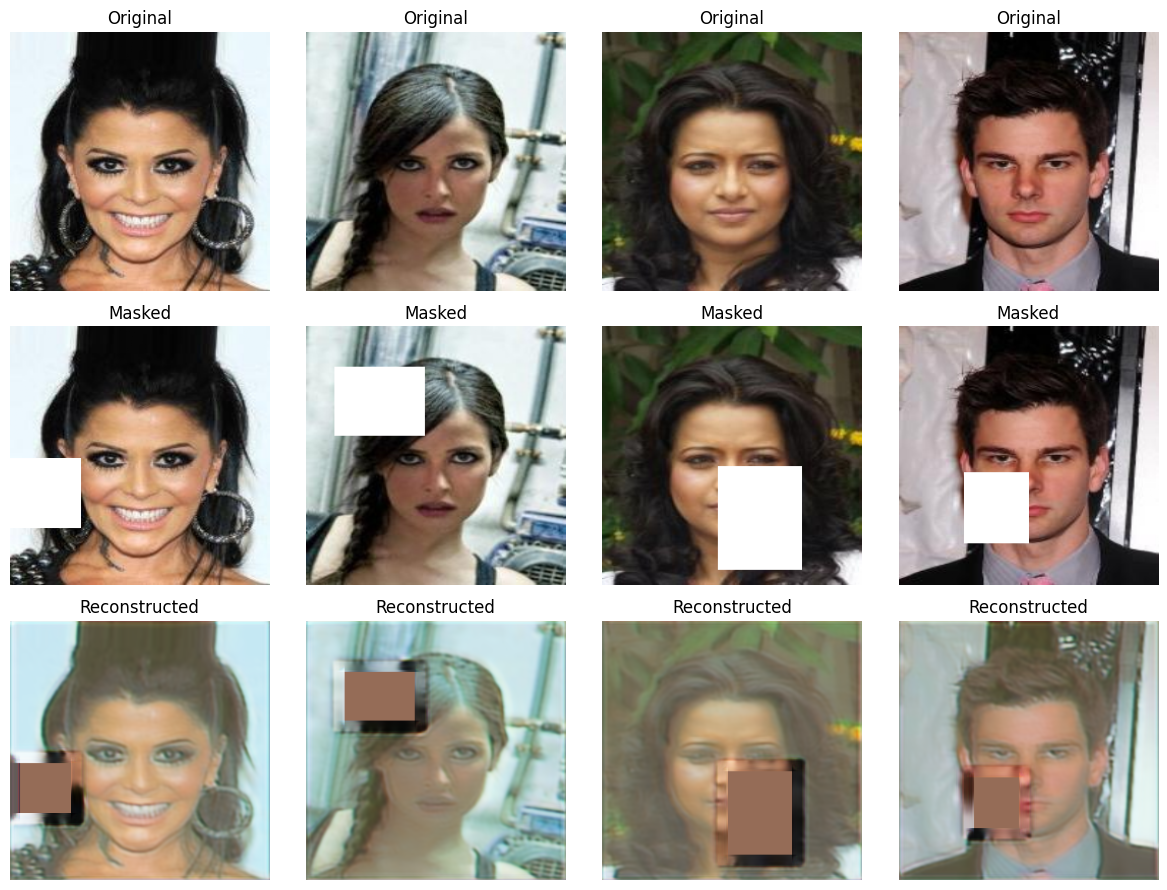

In [29]:
show_inpainting_result(originals, masked_imgs.cpu(), outputs)


In [30]:
model = InpaintingUNet().to(device)
model.load_state_dict(torch.load("unmasknet_weights.pth"))
model.eval()


InpaintingUNet(
  (encoder): Sequential(
    (0): Conv2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
  )
  (middle): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): Sigmoid()
  )
)

In [31]:
import torchvision.models as models
import torch.nn.functional as F

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:16]
        self.vgg = vgg.eval().to(device)
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        return F.mse_loss(self.vgg(x), self.vgg(y))


In [33]:
import torch.nn.functional as F
import torchvision.models as models
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# Load your model
model = InpaintingUNet().to(device)
model.load_state_dict(torch.load("unmasknet_weights.pth"))
model.train()

# VGG perceptual loss setup
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features[:16]  # conv3_3
        self.vgg = vgg.eval().to(device)
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        return F.mse_loss(self.vgg(x), self.vgg(y))

perceptual_criterion = VGGPerceptualLoss()
l1_criterion = nn.L1Loss()
scaler = GradScaler()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 2
best_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for masked_imgs, masks, originals in progress:
        masked_imgs = masked_imgs.to(device)
        masks = masks[:, :1, :, :].to(device)
        originals = originals.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(masked_imgs, masks)
            masked_region = (1 - masks)
            l1_loss = l1_criterion(outputs * masked_region, originals * masked_region)
            perc_loss = perceptual_criterion(outputs, originals)
            loss = l1_loss + 0.1 * perc_loss  # weighted combination

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "unmasknet_best.pth")
        print("💾 Best model saved with loss:", best_loss)


<ipython-input-33-f76f45f705f7>:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/2:   0%|          | 0/3125 [00:00<?, ?it/s]<ipython-input-33-f76f45f705f7>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/2: 100%|██████████| 3125/3125 [24:56<00:00,  2.09it/s, loss=0.0587]


Epoch [1/2] Avg Loss: 0.0588
💾 Best model saved with loss: 0.05882428944706917


Epoch 2/2: 100%|██████████| 3125/3125 [24:56<00:00,  2.09it/s, loss=0.062]

Epoch [2/2] Avg Loss: 0.0556
💾 Best model saved with loss: 0.055639201691150664


In [ ]:
model.load_state_dict(torch.load("unmasknet_best.pth"))
model.eval()

with torch.no_grad():
    masked_imgs, masks, originals = next(iter(dataloader))
    masked_imgs = masked_imgs.to(device)
    masks = masks[:, :1, :, :].to(device)
    outputs = model(masked_imgs, masks).cpu()

show_inpainting_result(originals, masked_imgs.cpu(), outputs)
